2023-12-09 11:47:04.680592: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Found 100000 files belonging to 2 classes.
0.0
255.0
3125
Epoch 1/10
3125/3125 [==============================] - 113s 36ms/step - loss: 0.3038 - accuracy: 0.8725 - val_loss: 0.4769 - val_accuracy: 0.8201 - lr: 9.5000e-04
Epoch 2/10
3125/3125 [==============================] - 109s 35ms/step - loss: 0.2242 - accuracy: 0.9115 - val_loss: 0.1795 - val_accuracy: 0.9304 - lr: 9.0250e-04
Epoch 3/10
3125/3125 [==============================] - 114s 36ms/step - loss: 0.2002 - accuracy: 0.9215 - val_loss: 0.1673 - val_accuracy: 0.9360 - lr: 8.5737e-04
Epoch 4/10
3125/3125 [==============================] - 111s 35ms/step - loss: 0.1831 - accuracy: 0.9280 - val_loss: 0.2196 - val_accuracy: 0.9108 - lr: 8.1451e-04
Epoch 5/10
3125/3125 [==============================] - 110s 35ms/step - loss: 0.1677 - accuracy: 0.9350 - val_loss: 0.1753 - val_accuracy: 0.9313 - lr: 7.7378e-04
Epoch 6/10
313/313 [==============================] - 6s 14ms/step - loss: 0.1691 - accuracy: 0.9381
Test Accuracy: 93.81%

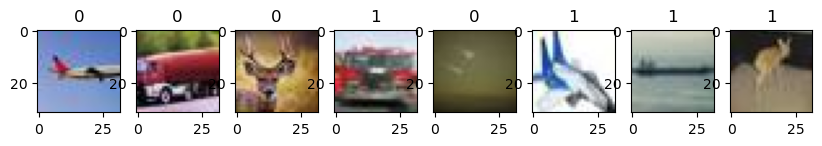

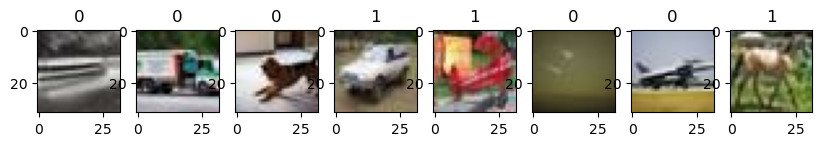

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from matplotlib import pyplot as plt

# GPU memory growth configuration
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Load image dataset
data = tf.keras.utils.image_dataset_from_directory('./train', image_size=(32, 32))

# Visualize a batch of images
data_it = data.as_numpy_iterator()
batch = data_it.next()

fig, ax = plt.subplots(ncols=8, figsize=(10, 10))
for idx, img in enumerate(batch[0][:8]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

print(batch[0].min())
print(batch[0].max())

# Scale pixel values to the range [0, 1]
data = data.map(lambda x, y : (x/255, y))

# Visualize a scaled batch of images
scaled_it = data.as_numpy_iterator()
batch = scaled_it.next()

fig, ax = plt.subplots(ncols=8, figsize=(10, 10))
for idx, img in enumerate(batch[0][:8]):
    ax[idx].imshow(img.astype(float))
    ax[idx].title.set_text(batch[1][idx])

# Split the dataset
train_size = int(len(data) * 0.7)
cv_size = int(len(data) * 0.2)
test_size = int(len(data) * 0.1) + 1

train = data.take(train_size)
cv = data.skip(train_size).take(cv_size)
test = data.skip(train_size + cv_size).take(test_size)

print(len(train) + len(cv) + len(test))


# Define the CNN model with enhancements
model = models.Sequential()

model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# Learning rate scheduler
initial_learning_rate = 0.001
def lr_scheduler(epoch, lr):
    return lr * 0.95  # Adjust the decay factor as needed
lr_schedule = LearningRateScheduler(lr_scheduler)
optimizer = Adam(learning_rate=initial_learning_rate)

# Compile the model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Data Augmentation in the pipeline
def augment_data(x, y):
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_flip_up_down(x)
    x = tf.image.random_brightness(x, max_delta=0.1)
    x = tf.image.random_contrast(x, lower=0.9, upper=1.1)
    return x, y

train_augmented = data.map(augment_data)

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(train_augmented, validation_data=cv, epochs=10, callbacks=[lr_schedule, early_stopping])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

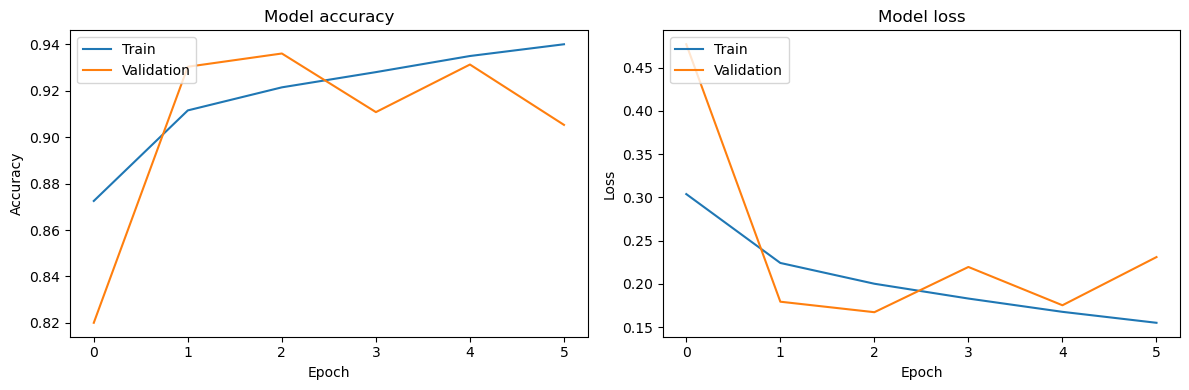

In [2]:
##################################### Plotting Model Accuracy & Loss #####################################
##########################################################################################################
# Plot accuracy and loss
# to visualize the changes in accuracy and loss of a machine learning model during the model training process. 
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [3]:
##################################### Precision, Recall & Accuracy #####################################
########################################################################################################
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

pre = Precision()
rec = Recall() # used to evaluate the performance of a classification model.
acc = BinaryAccuracy() # evaluate the accuracy of binary classification models

for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    rec.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 25ms/step


In [4]:
print(f'Precision: {pre.result().numpy()}, Recall: {rec.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision: 0.9626786112785339, Recall: 0.9111828804016113, Accuracy: 0.9385982155799866


In [5]:
##################################### Save & Loaded The Model #####################################
###################################################################################################
from tensorflow.keras.models import load_model
from keras.models import load_model

# Assuming 'model' is your Keras model
model.save('model/ai_imageclassifier', save_format='tf')

loaded_model = tf.keras.models.load_model('model/ai_imageclassifier')

INFO:tensorflow:Assets written to: model/ai_imageclassifier/assets


INFO:tensorflow:Assets written to: model/ai_imageclassifier/assets


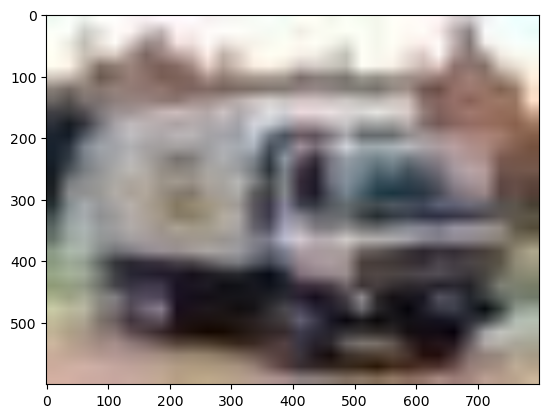

In [6]:
#Model Prediction On Any Single Image

import cv2
import matplotlib.pyplot as plt

# Load the image
image_path = './test/REAL/0000 (10).jpg'

try:
    img = cv2.imread(image_path)

    # Check if the image is loaded successfully
    if img is None:
        raise FileNotFoundError(f"Could not read the image from {image_path}")

    # Resize the image to a larger size
    img = cv2.resize(img, (800, 600))

    # Convert from BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the resized image
    plt.imshow(img)
    plt.show()

except Exception as e:
    print(f"Error: {e}")

In [7]:
import numpy as np

resize = tf.image.resize(img, (32, 32))
y_pred = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 103ms/step


In [8]:
y_pred

array([[0.9780997]], dtype=float32)

In [9]:
if y_pred > 0.5: 
    print(f'Predicted class: REAL')
else:
    print(f'Predicted class: AI')

Predicted class: REAL


2/2 [==============================] - 0s 9ms/step


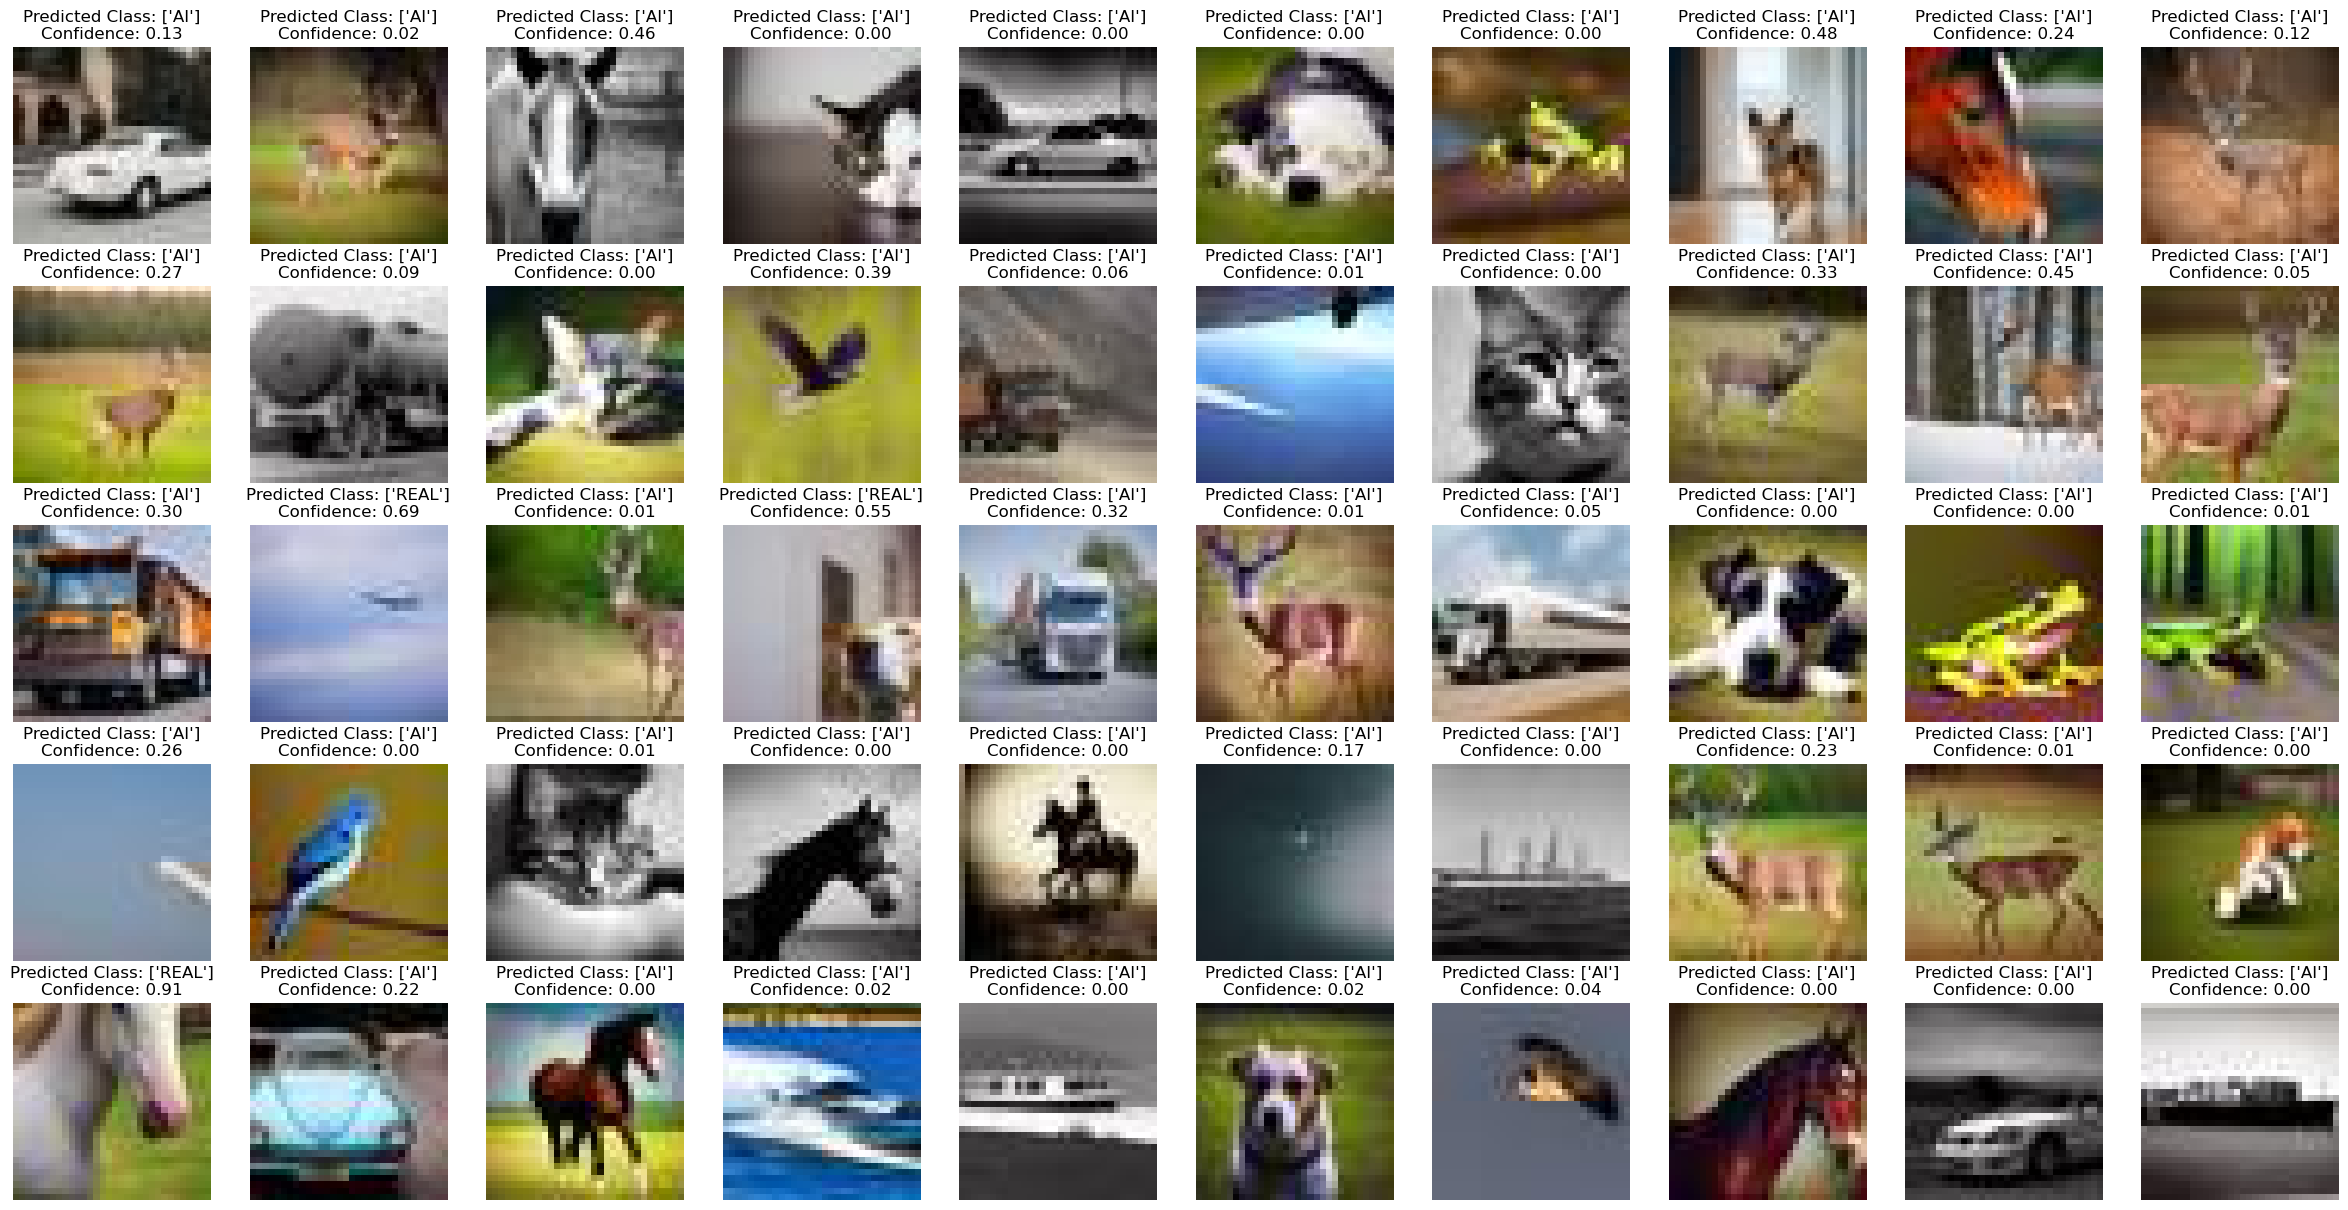

In [10]:
# Model Prediction On Whole Test Dataset

from tensorflow.keras.models import load_model
import os
import cv2
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

# Load the trained model
model_path = os.path.join('model', 'ai_imageclassifier')
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model file '{model_path}' not found.")
model = load_model(model_path)

# Define a function to preprocess an image
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = tf.image.resize(img, (32, 32))
    return img_resized / 255.0

# Define the path to the test images
test_images_path = './test'

# Collect all image paths
image_paths = [os.path.join(root, file) for root, dirs, files in os.walk(test_images_path)
               for file in files if file.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Display the first 50 images
num_images_to_display = 50
image_paths_to_display = image_paths[:num_images_to_display]
preprocessed_images = [preprocess_image(img_path) for img_path in image_paths_to_display]
input_images = np.stack(preprocessed_images)
predictions = model.predict(input_images)
predicted_classes = np.where(predictions > 0.5, 'REAL', 'AI')

# Display the results
plt.figure(figsize=(30, 15))
for i, (img_path, pred_class, confidence) in enumerate(zip(image_paths_to_display, predicted_classes, predictions)):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(5, 10, i + 1)
    plt.imshow(img)
    plt.title(f'Predicted Class: {pred_class}\nConfidence: {confidence[0]:.2f}')
    plt.axis('off')
plt.show()

1/1 [==============================] - 0s 22ms/step


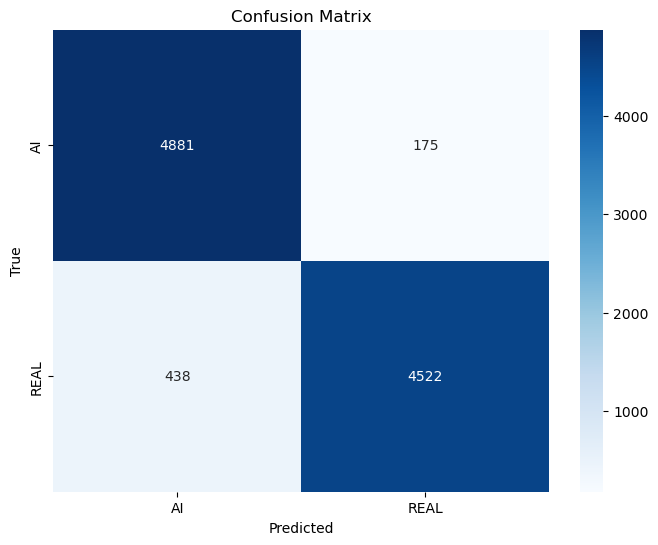

Classification Report:
               precision    recall  f1-score   support

          AI       0.92      0.97      0.94      5056
        REAL       0.96      0.91      0.94      4960

    accuracy                           0.94     10016
   macro avg       0.94      0.94      0.94     10016
weighted avg       0.94      0.94      0.94     10016



In [11]:
# Classification Report & Confusion Matrix

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# ...

# Evaluate the model on the test set
y_true = []
y_pred_probs = []

for batch in test.as_numpy_iterator():
    X, y = batch
    y_true.extend(y)
    y_pred_probs.extend(model.predict(X).flatten())

# Convert probabilities to binary predictions
y_pred = np.array(y_pred_probs) > 0.5

# Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred)

# Classification Report
class_report = classification_report(y_true, y_pred, target_names=['AI', 'REAL'])

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['AI', 'REAL'], yticklabels=['AI', 'REAL'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Display Classification Report
print("Classification Report:\n", class_report)